In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, ClassifierMixin, clone
import copy
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
import warnings
warnings.filterwarnings('ignore')



# Dataset
30000 data that have 2 features

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

y_train=train.iloc[:,3]
y_test=test.iloc[:,3]
X_train=train.drop(train.columns[[0,3]], axis=1)
X_test=test.drop(test.columns[[0,3]], axis=1)

y_train=np.array(y_train)
y_test=np.array(y_test)
X_train=np.array(X_train)
X_test=np.array(X_test)


Visual train dataset 

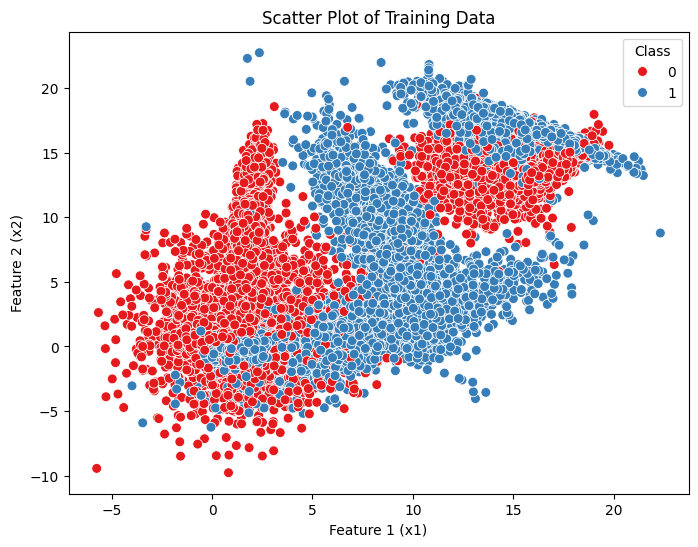

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=train['x'], y=train['y'], hue=train['cls'], palette='Set1', s=50)

plt.title('Scatter Plot of Training Data')
plt.xlabel('Feature 1 (x1)')
plt.ylabel('Feature 2 (x2)')
plt.legend(title='Class')
plt.show()

## Accuracy & n_estimators plot

In [4]:
def plot_accuracy_vs_n_estimators(model, X_train, y_train, X_test, y_test, n_estimators_range):
    train_accuracies = []
    test_accuracies = []
    
    for n_estimators in n_estimators_range:
        temp_model = clone(model)
        temp_model.set_params(n_estimators=n_estimators)
        
        temp_model.fit(X_train, y_train)
        
        y_train_pred = temp_model.predict(X_train)
        y_test_pred = temp_model.predict(X_test)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))
        test_accuracies.append(accuracy_score(y_test, y_test_pred))
    
    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators_range, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(n_estimators_range, test_accuracies, label='Test Accuracy', marker='s')
    plt.title('Accuracy vs. Number of Estimators')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


## Report Metrics

In [5]:
def Report(model, X_train, y_train, X_test, y_test):

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
    
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    
    results = {
        "Training": {
            "Accuracy": train_accuracy,
            "Precision": train_precision,
            "Recall": train_recall,
            "F1 Score": train_f1
        },
        "Test": {
            "Accuracy": test_accuracy,
            "Precision": test_precision,
            "Recall": test_recall,
            "F1 Score": test_f1
        }
    }
    
    return pd.DataFrame(results)


## GridSerach Function

In [6]:
def perform_grid_search(estimator, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator, param_grid, scoring="accuracy", cv=5)
    grid_search.fit(X_train, y_train)
    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_
    return best_estimator, best_params


# Phase1: Bagging

### Manual Bagging

In [7]:
class BaggingClassifierManual(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=5, max_depth=4):
        self.base_estimator = base_estimator or DecisionTreeClassifier
        self.n_estimators = n_estimators
        self.max_depth = max_depth

    def fit(self, X, y):
        self.models_ = []
        n_samples = X.shape[0]

        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]
            
            model = self.base_estimator(max_depth=self.max_depth)
            model.fit(X_bootstrap, y_bootstrap)
            self.models_.append(model)

        return self

    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self.models_)))
        for i, model in enumerate(self.models_):
            predictions[:, i] = model.predict(X)
        final_predictions = [np.bincount(predictions[i].astype(int)).argmax() for i in range(X.shape[0])]
        return np.array(final_predictions)


Use grid search to fine best parameters for training

In [8]:
model = BaggingClassifierManual()
param_grid = {
    "n_estimators": [10, 15, 25,50,100],
    "max_depth": [5, 7, 10]
}

best_model_bagging_manual, best_params_bagging_manual = perform_grid_search(model, param_grid,X_train, y_train)
print("Best Parameters:", best_params_bagging_manual)


Best Parameters: {'max_depth': 5, 'n_estimators': 10}


Accuracy, Precision, Recall, F1 Score 

In [9]:
Report(best_model_bagging_manual, X_train, y_train, X_test, y_test)

Training      Test
Accuracy   0.859792  0.856667
Precision  0.859835  0.856667
Recall     0.859792  0.856667
F1 Score   0.859789  0.856666

Plot accuracy per estimator in range 1 to 100

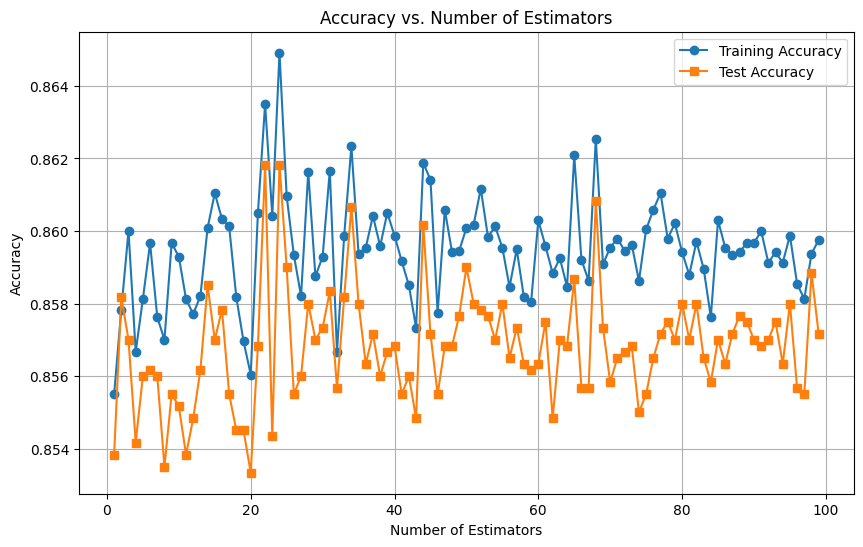

In [10]:
plot_accuracy_vs_n_estimators(best_model_bagging_manual, X_train, y_train, X_test, y_test, range(1,100))

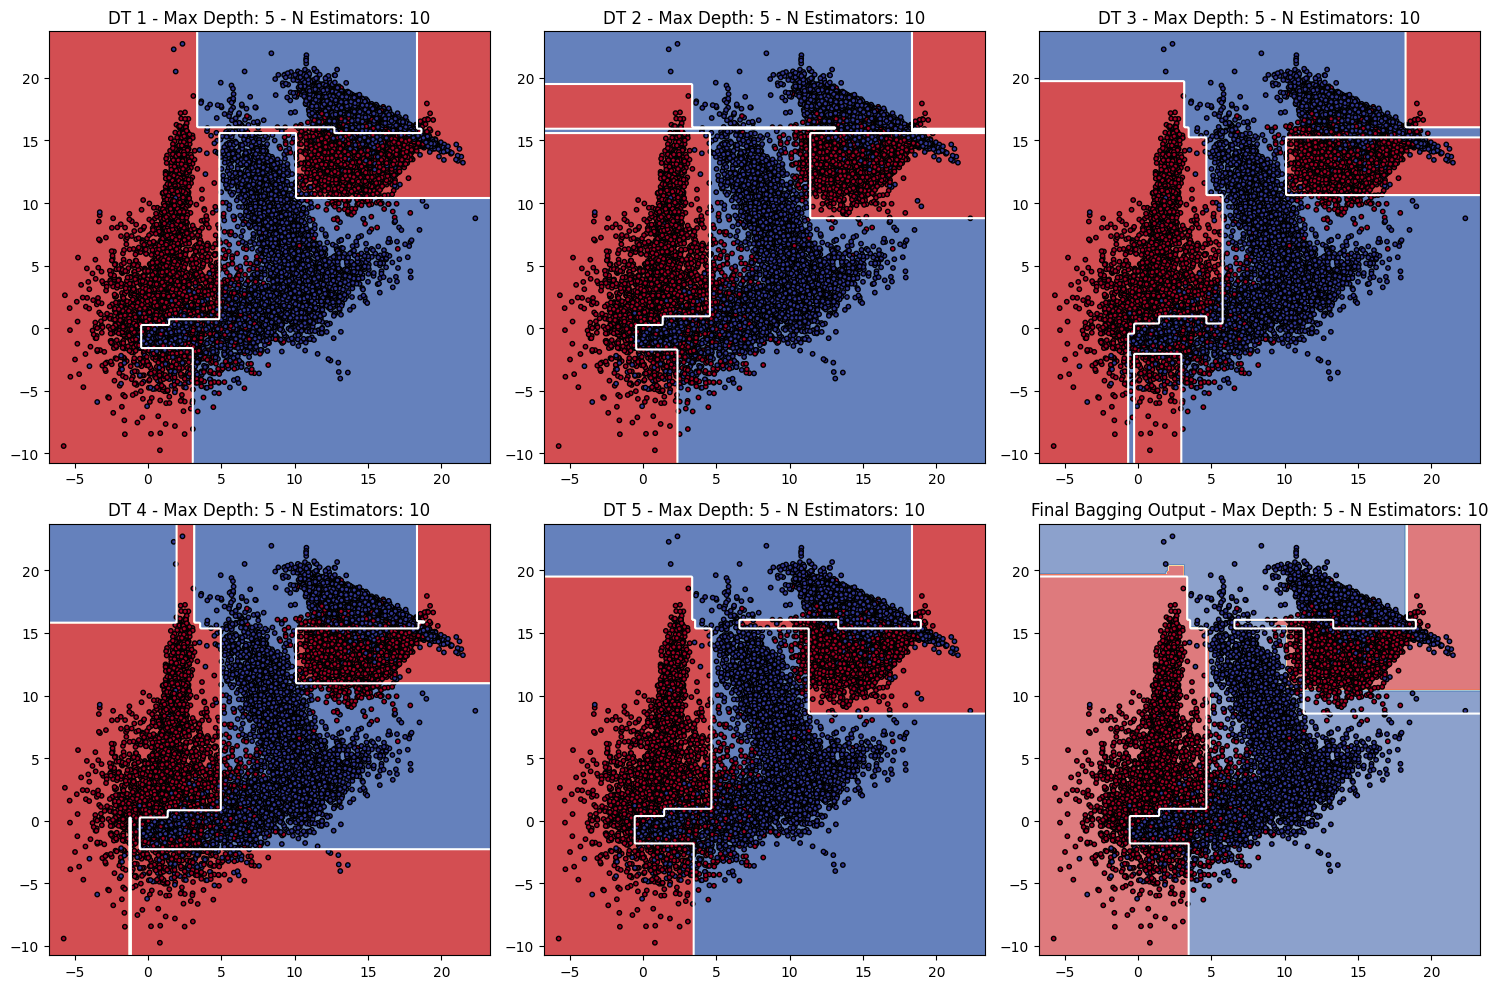

In [ ]:
def plot_decision_boundaries_Bagging(bagging_model, sk, X_train, y_train, best_params):
    if bagging_model is not None:
        models = bagging_model.models_
    else:
        models = sk.estimators_
    
    plt.figure(figsize=(15, 10))
    max_depth = best_params.get('max_depth', best_params.get('estimator__max_depth', None))
    n_estimators = best_params.get('n_estimators', 'N/A')
    
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    for i, model in enumerate(models[:5]):
        plt.subplot(2, 3, i + 1)
        
        Z = model.predict(grid)
        Z = Z.reshape(xx.shape)
        
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
        plt.contour(xx, yy, Z, levels=[0.5], colors='white', linewidths=1.5)

        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu, s=10, edgecolor="k")
        
        plt.title(f"DT {i + 1} - Max Depth: {max_depth} - N Estimators: {n_estimators}")
    
    plt.subplot(2, 3, 6)
    predictions = np.array([model.predict(grid) for model in models])
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
    final_predictions = final_predictions.reshape(xx.shape)
    
    plt.contourf(xx, yy, final_predictions, alpha=0.6, cmap=plt.cm.RdYlBu)
    plt.contour(xx, yy, Z, levels=[0.5], colors='white', linewidths=1.5)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu, s=10, edgecolor="k")
    plt.title(f"Final Bagging Output - Max Depth: {max_depth} - N Estimators: {n_estimators}")
    
    plt.tight_layout()
    plt.show()

plot_decision_boundaries_Bagging(best_model_bagging_manual, "", X_train, y_train, best_params_bagging_manual)


### Sklearn Bagging
implement this method with sklearn library

In [12]:
param_grid = {
    'estimator__max_depth': [3, 5, 7, 10], 
    'n_estimators': [3, 5, 10, 15],  
}

bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    random_state=42
)

best_model_sklearn,best_params_sklearn =perform_grid_search(bagging_model, param_grid, X_train, y_train)
print("best parameter: ", 'n_estimators',best_params_sklearn['n_estimators'], 'max_depth',best_params_sklearn['estimator__max_depth'])



best parameter:  n_estimators 15 max_depth 10


Accuracy, Precision, Recall, F1 Score 

In [13]:
Report(best_model_sklearn, X_train, y_train, X_test, y_test)

Training      Test
Accuracy   0.898875  0.871333
Precision  0.899269  0.871802
Recall     0.898875  0.871333
F1 Score   0.898848  0.871306

Plot accuracy per estimator in range 1 to 50

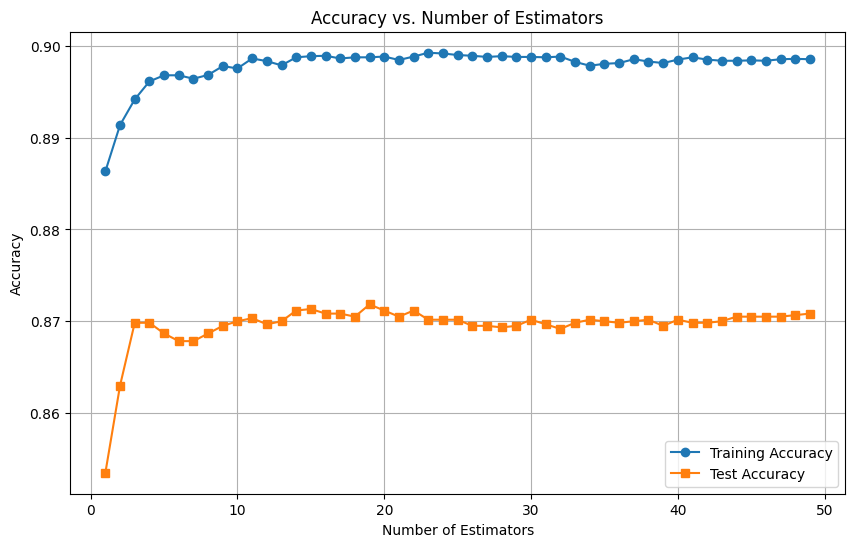

In [14]:
plot_accuracy_vs_n_estimators(best_model_sklearn, X_train, y_train, X_test, y_test, range(1, 50))


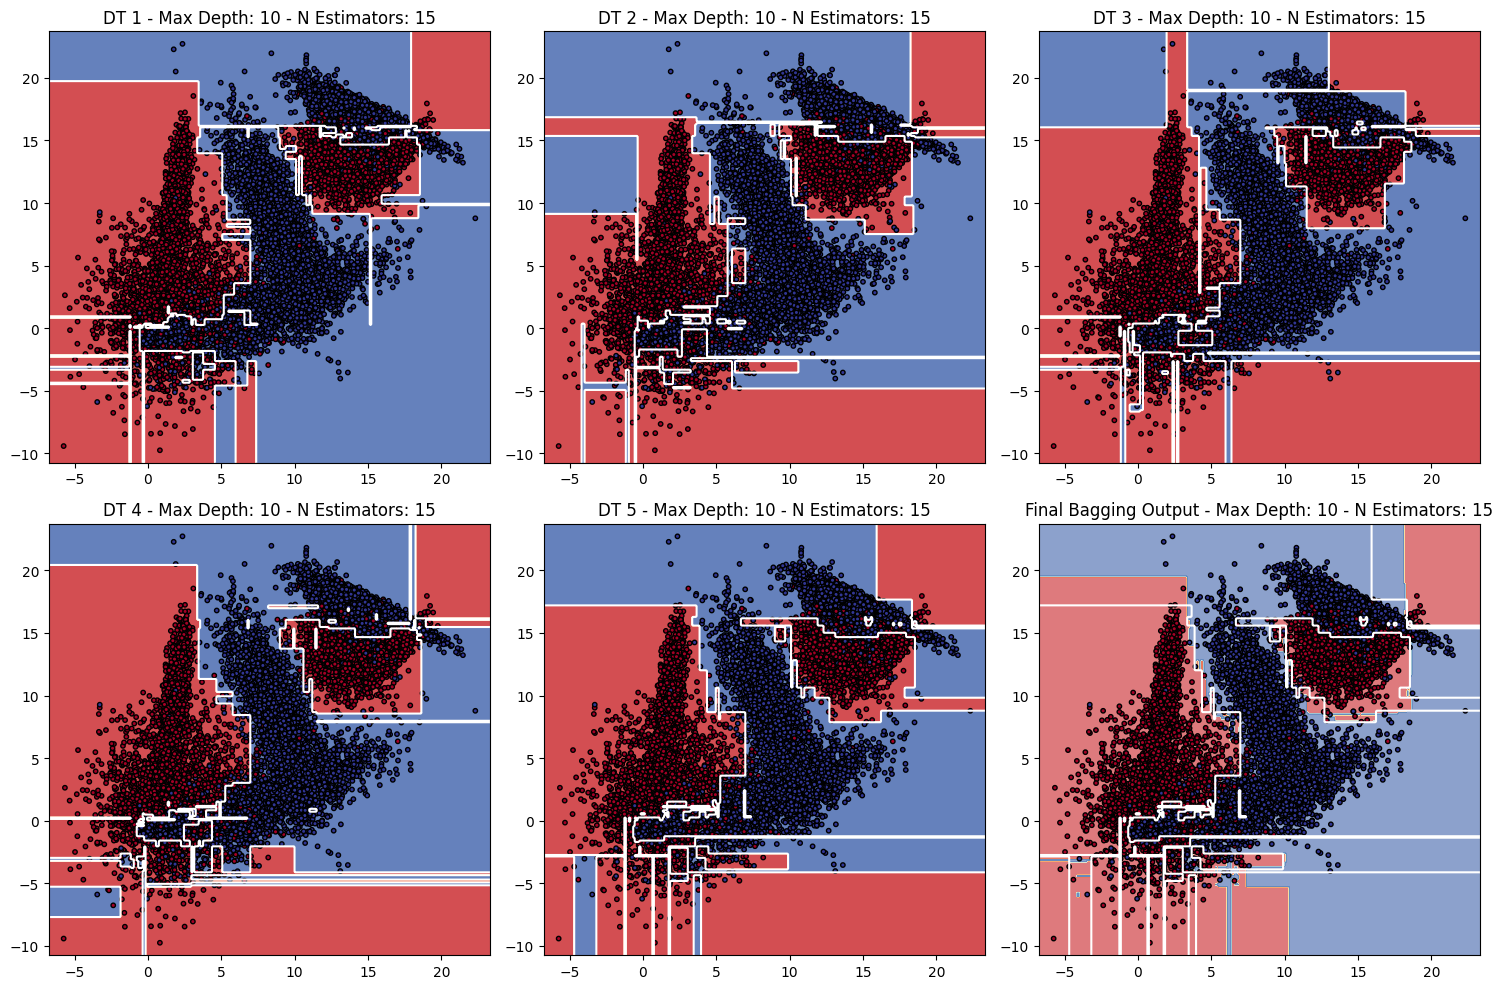

In [54]:
plot_decision_boundaries_Bagging(None,best_model_sklearn, X_train, y_train, best_params_sklearn)


# Phase2: Random Forest

### Manual Random Forest

In [18]:
class RandomForestManual(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=5, max_depth=5, max_features='sqrt'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.models_ = []
    
    def fit(self, X, y):
        n_samples = X.shape[0]
        
        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]
            
            n_features = X.shape[1]
            if self.max_features == 'sqrt':
                selected_features = np.random.choice(n_features, int(np.sqrt(n_features)), replace=False)
            elif self.max_features == 'log2':
                selected_features = np.random.choice(n_features, int(np.log2(n_features)), replace=False)
            else:
                selected_features = np.arange(n_features)
            
            model = DecisionTreeClassifier(max_depth=self.max_depth, random_state=42)
            model.fit(X_bootstrap[:, selected_features], y_bootstrap)
            self.models_.append((model, selected_features))
        
        return self
    
    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self.models_)))
        for i, (model, features) in enumerate(self.models_):
            predictions[:, i] = model.predict(X[:, features])
        
        final_predictions = [np.bincount(predictions[i].astype(int)).argmax() for i in range(X.shape[0])]
        return np.array(final_predictions)



Use grid search to fine best parameters for training

In [19]:
model = RandomForestManual()
param_grid = {
    "n_estimators": [10, 15],
    "max_depth": [5, 7, None],
    "max_features": [None,'sqrt', 'log2']
}

best_model_rf_manual, best_params_rf_manual = perform_grid_search(model, param_grid, X_train, y_train)
print("best_params", best_params_rf_manual)


best_params {'max_depth': 5, 'max_features': None, 'n_estimators': 10}


Accuracy, Precision, Recall, F1 Score 

In [20]:
Report(best_model_rf_manual, X_train, y_train , X_test, y_test)


Training      Test
Accuracy   0.856583  0.854833
Precision  0.856732  0.854909
Recall     0.856583  0.854833
F1 Score   0.856571  0.854819

Plot accuracy per estimator in range 1 to 100

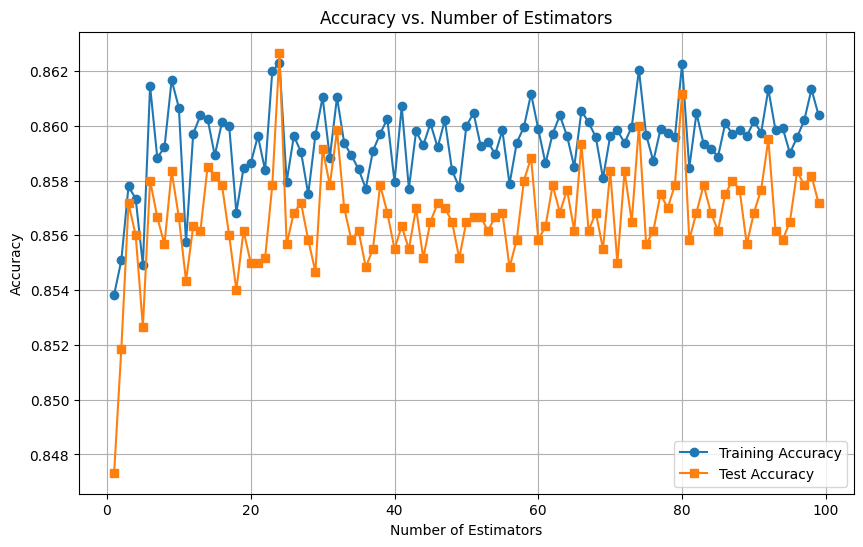

In [162]:
plot_accuracy_vs_n_estimators(best_model_rf_manual, X_train, y_train, X_test, y_test, range(1,100))

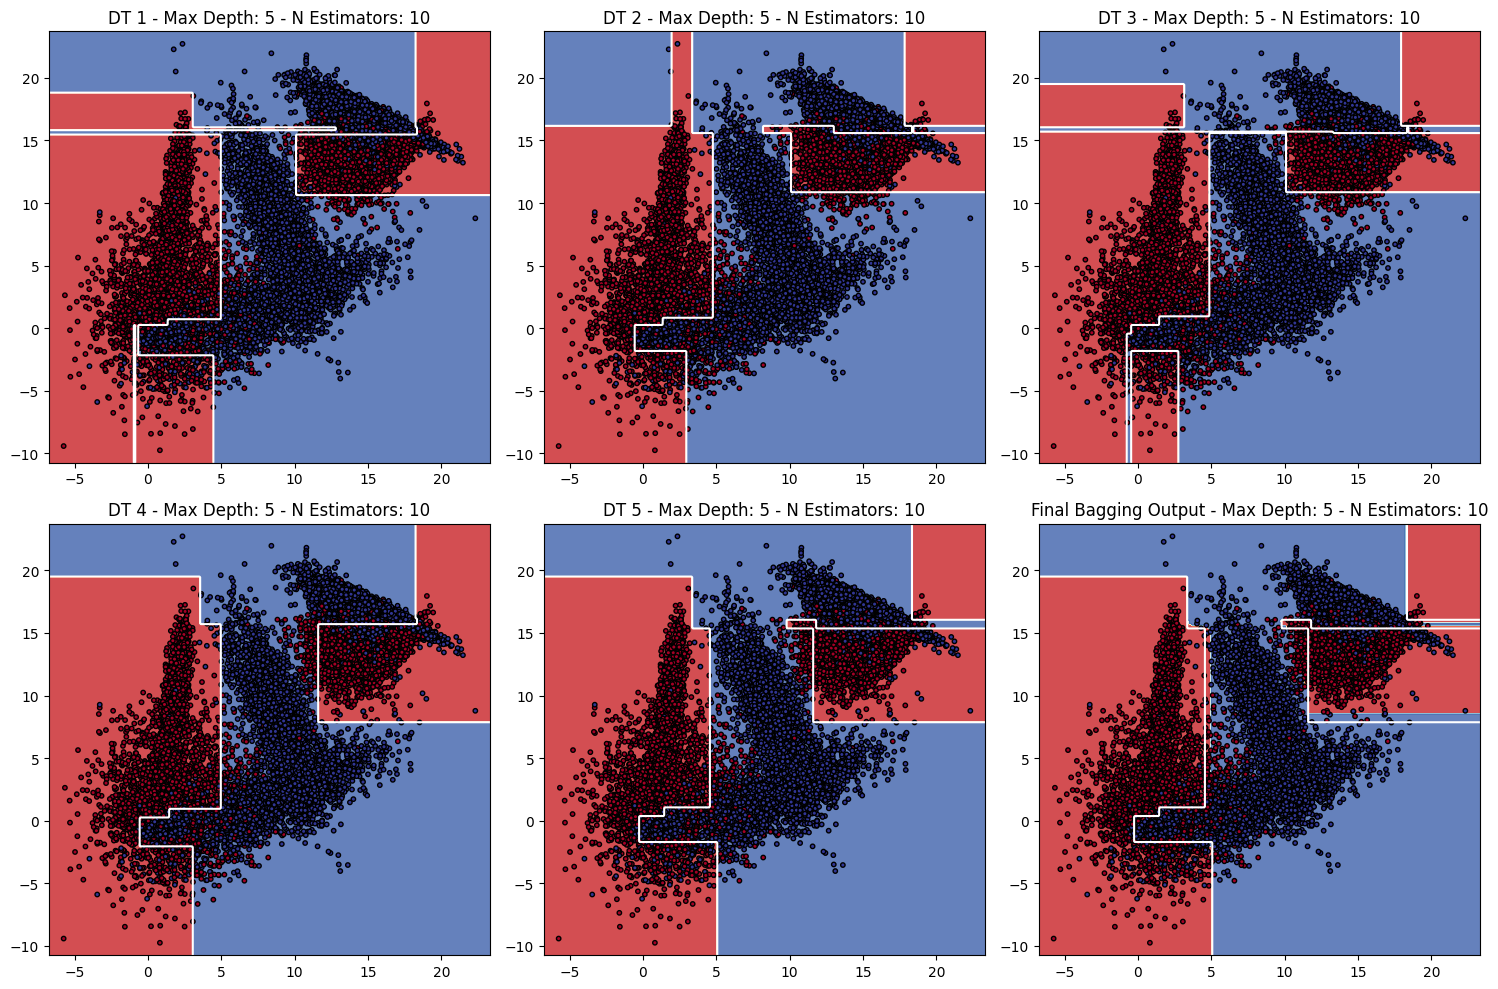

In [56]:
def plot_decision_boundaries_rf(bagging_model, X_train, y_train, best_params):
    models = bagging_model.models_
   

    plt.figure(figsize=(15, 10))

    max_depth = best_params.get('max_depth', best_params.get('estimator__max_depth', None))
    n_estimators = best_params.get('n_estimators', 'N/A')
    
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]  
    
    for i, (model, selected_features) in enumerate(models[:5]):
        plt.subplot(2, 3, i + 1)
        
        grid_selected = grid[:, selected_features]
        Z = model.predict(grid_selected) 
        Z = Z.reshape(xx.shape) 
        
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
        plt.contour(xx, yy, Z, levels=[0.5], colors='white', linewidths=1.5)
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu, s=10, edgecolor="k")
        plt.title(f"DT {i + 1} - Max Depth: {max_depth} - N Estimators: {n_estimators}")
    
    plt.subplot(2, 3, 6)
    final_predictions = np.zeros(grid.shape[0], dtype=int)
    for i, (model, selected_features) in enumerate(models):
        grid_selected = grid[:, selected_features]
        final_predictions += model.predict(grid_selected)

    final_predictions = (final_predictions > len(models) / 2).astype(int)
    Z_final = final_predictions.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z_final, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.contour(xx, yy, Z, levels=[0.5], colors='white', linewidths=1.5)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu, s=10, edgecolor="k")
    plt.title(f"Final Bagging Output - Max Depth: {max_depth} - N Estimators: {n_estimators}")
    plt.tight_layout()
    plt.show()

plot_decision_boundaries_rf(best_model_rf_manual, X_train, y_train, best_params_rf_manual)


### Sklearn Random Forest
implement this method with sklearn library

In [ ]:
param_grid = {
    'n_estimators': [10, 50, 80],
    'max_depth': [5, 10, 20, None],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestClassifier(random_state=42)

best_model_sklearn_rf, best_params_sklearn_rf =perform_grid_search(rf_model, param_grid, X_train, y_train)

print("best parameter", best_params_sklearn_rf)



best parameter {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 80}


Accuracy, Precision, Recall, F1 Score 

In [27]:
Report(best_model_sklearn_rf,X_train, y_train,X_test, y_test)

Training      Test
Accuracy   0.894708  0.872167
Precision  0.895163  0.872799
Recall     0.894708  0.872167
F1 Score   0.894675  0.872128

Plot accuracy per estimator in range 1 to 50

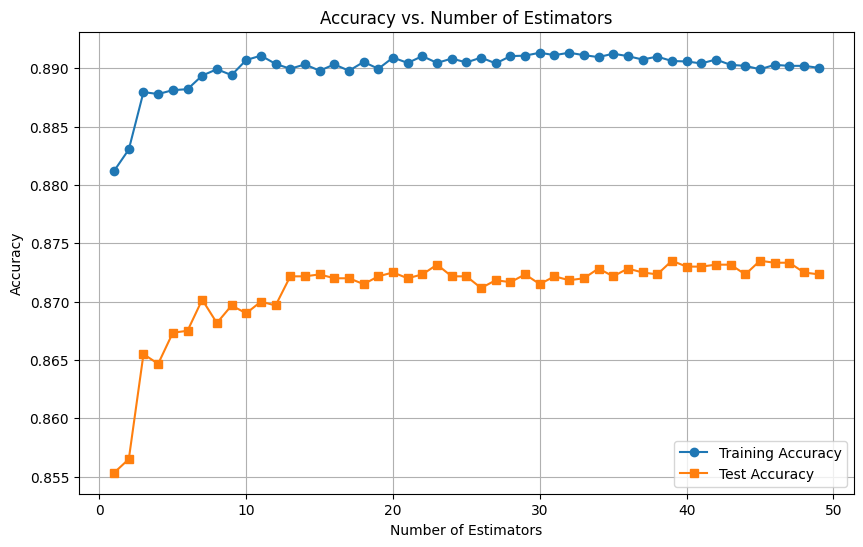

In [14]:
def plot_accuracy_vs_n_estimators_sklearn_rf(models, X_train, y_train, X_test, y_test, n_estimators_range):
    train_accuracies = []
    test_accuracies = []

    for n_estimators in n_estimators_range:
        temp_models = models[:n_estimators]

        def majority_vote(models, X):
            predictions = np.zeros((X.shape[0], len(models)))
            for i, model in enumerate(models):  
                predictions[:, i] = model.predict(X)  
            final_predictions = [np.bincount(predictions[i].astype(int)).argmax() for i in range(X.shape[0])]
            return np.array(final_predictions)

        y_train_pred = majority_vote(temp_models, X_train)
        y_test_pred = majority_vote(temp_models, X_test)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))
        test_accuracies.append(accuracy_score(y_test, y_test_pred))

    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators_range, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(n_estimators_range, test_accuracies, label='Test Accuracy', marker='s')
    plt.title('Accuracy vs. Number of Estimators')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

plot_accuracy_vs_n_estimators_sklearn_rf(best_model_sklearn_rf.estimators_, X_train, y_train, X_test, y_test, range(1,50))


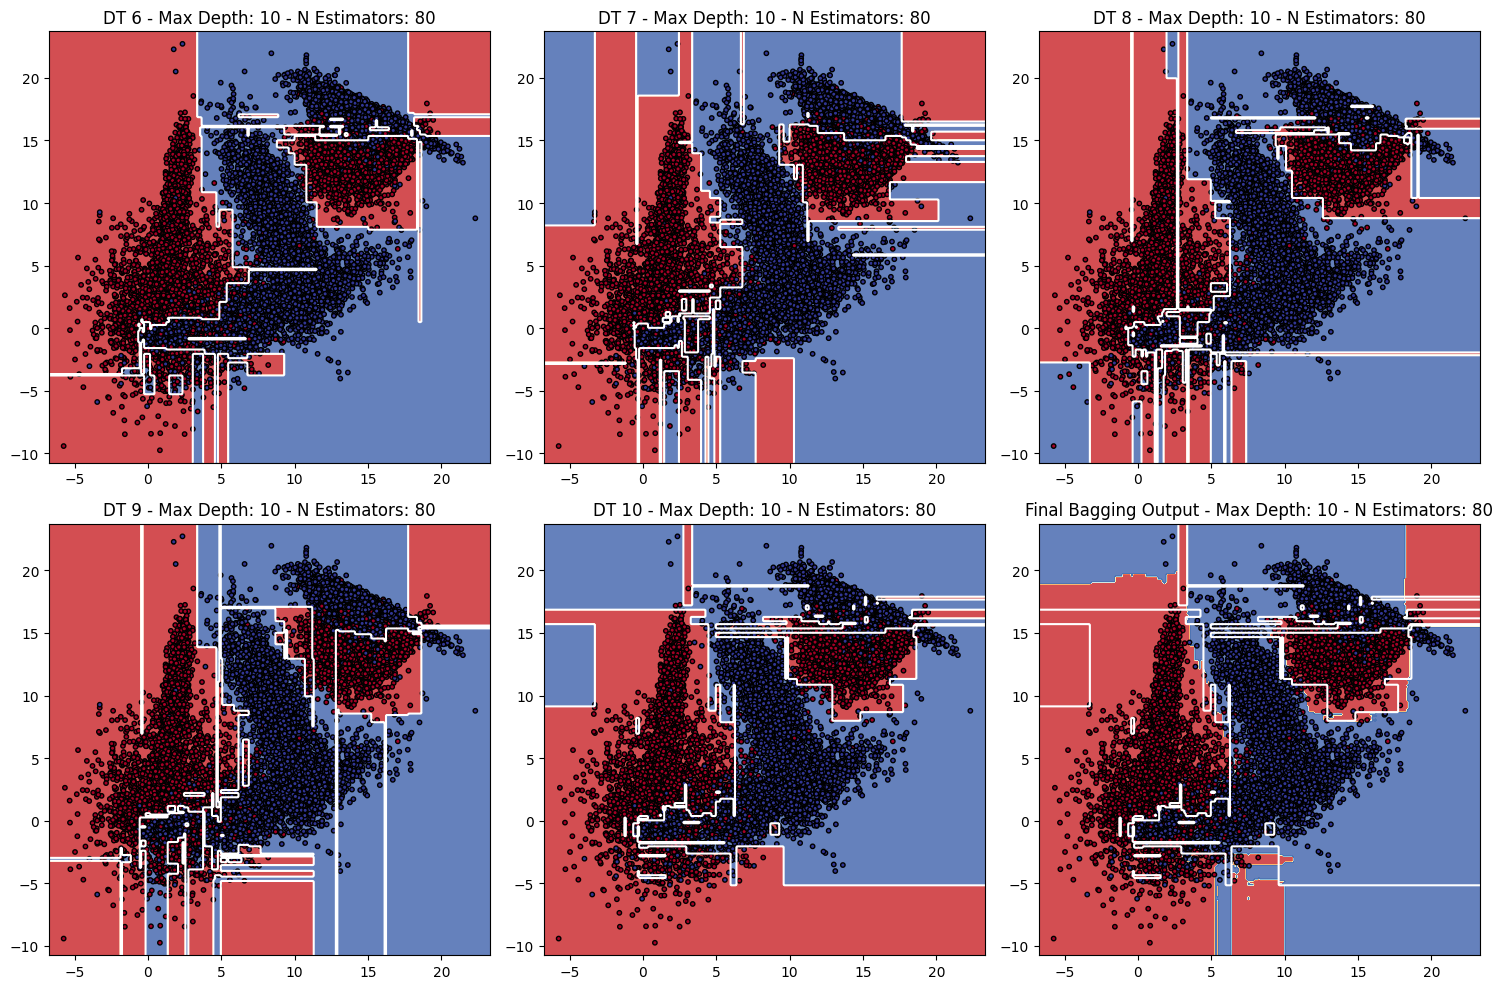

In [57]:
def plot_decision_boundaries_rf_sklearn(models, X_train, y_train, best_params):
    plt.figure(figsize=(15, 10))

    max_depth = best_params.get('max_depth', best_params.get('estimator__max_depth', None))
    n_estimators = best_params.get('n_estimators', 'N/A')

    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()] 

    models = models[0] if isinstance(models, tuple) else models
    for i, model in enumerate(models[5:10]):
        plt.subplot(2, 3, i + 1)

     
        Z = model.predict(grid)
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
        plt.contour(xx, yy, Z, levels=[0.5], colors='white', linewidths=1.5)

        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu, s=10, edgecolor="k")
        plt.title(f"DT {i + 6} - Max Depth: {max_depth} - N Estimators: {n_estimators}")

    plt.subplot(2, 3, 6)
    predictions = np.array([model.predict(grid) for model in models])  
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=predictions)
    final_predictions = final_predictions.reshape(xx.shape)

    plt.contourf(xx, yy, final_predictions, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.contour(xx, yy, Z, levels=[0.5], colors='white', linewidths=1.5)

    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu, s=10, edgecolor="k")
    plt.title(f"Final Bagging Output - Max Depth: {max_depth} - N Estimators: {n_estimators}")

    plt.tight_layout()
    plt.show()

plot_decision_boundaries_rf_sklearn(best_model_sklearn_rf.estimators_, X_train, y_train, best_params_sklearn_rf)


# Phase3: AdaBoosting

### HyperParameter Tuning

In [ ]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 1],
    'estimator': [DecisionTreeClassifier(max_depth=1),
                  DecisionTreeClassifier(max_depth=2),
                  DecisionTreeClassifier(max_depth=3),
                  DecisionTreeClassifier(max_depth=4),
                  DecisionTreeClassifier(max_depth=5)]
}
ada = AdaBoostClassifier(random_state=42)

ada_best, best_params = perform_grid_search(ada, param_grid, X_train, y_train)

print(f"Best Parameters: {best_params}")
dump(ada_best, 'ada_best.joblib')
dump(best_params, 'best_params.joblib')



In [33]:
ada_best=load("ada_best.joblib")
best_params=load("best_params.joblib")

## Plot Decision Bounderies

In [34]:
def plot_decision_boundaries_from_model(model, X, y, states):
    
   
    if hasattr(X, 'iloc'): 
        X = X.values
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.01), 
        np.arange(y_min, y_max, 0.01)
    )
    
    plt.figure(figsize=(15, 10))
    
    for index,state in enumerate(states):
        predictions = np.zeros(xx.ravel().shape)
        for i, (estimator, weight) in enumerate(zip(model.estimators_[:state], model.estimator_weights_[:state])):
            predictions += weight * estimator.predict(np.c_[xx.ravel(), yy.ravel()])

        Z = np.sign(predictions).reshape(xx.shape)
        
        plt.subplot(2, 9 // 2, index+1)
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.RdYlBu)
        plt.title(f'State {state}')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
    
    plt.tight_layout()
    plt.show()


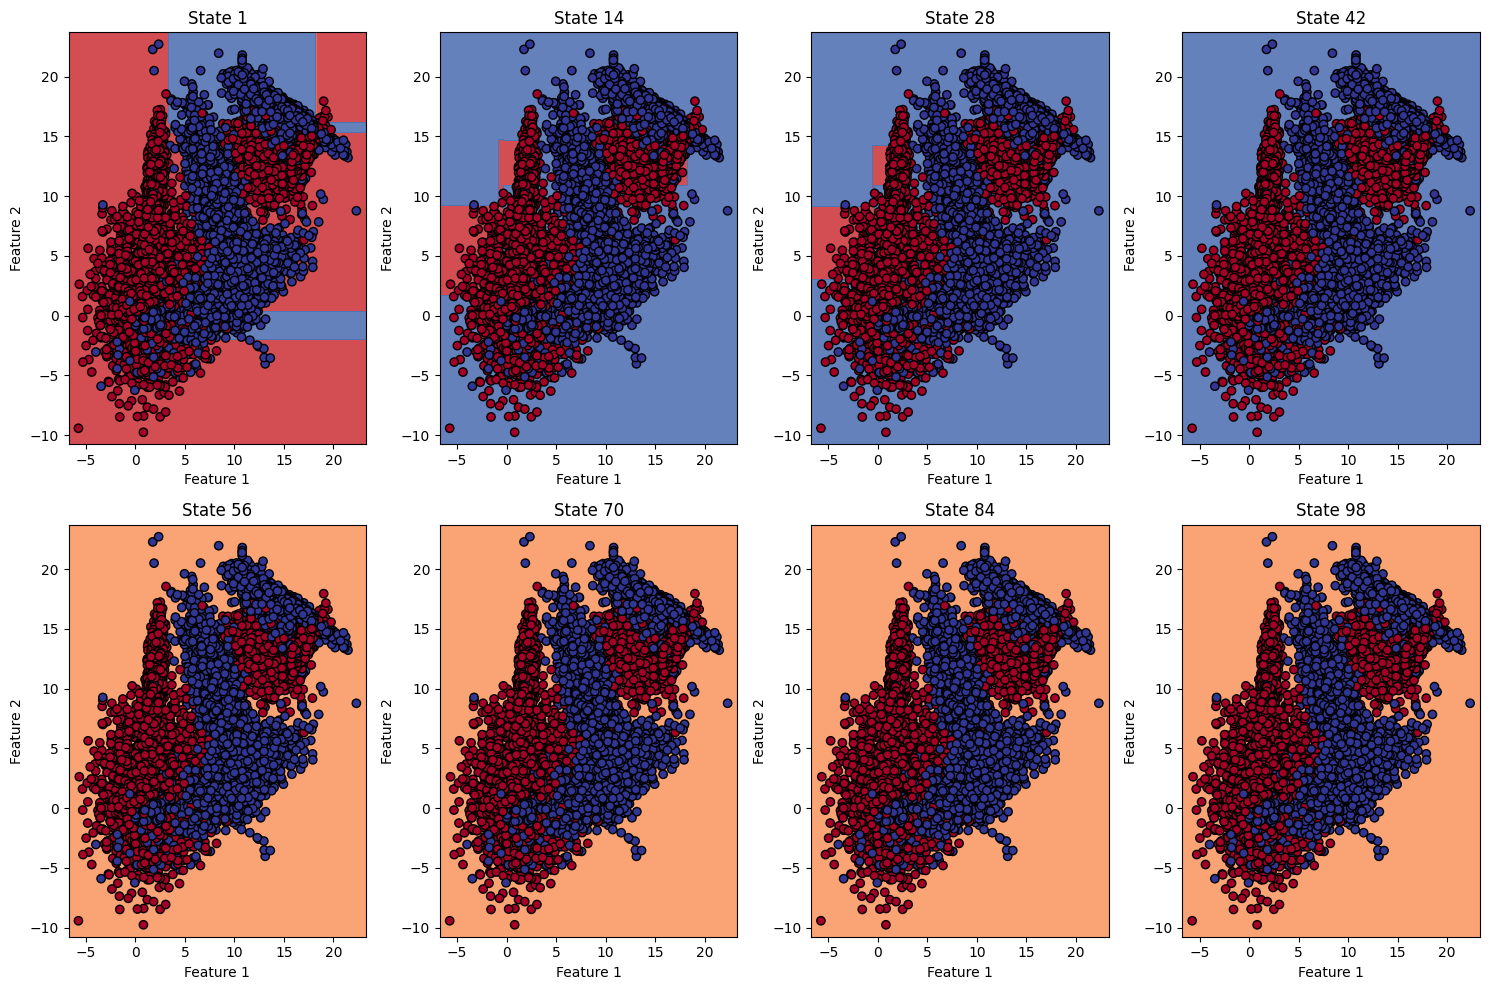

In [ ]:
sliced=100//7

states = [1,sliced , 2*sliced, 3*sliced, 4*sliced,5*sliced, 6*sliced, 7*sliced]
plot_decision_boundaries_from_model(ada_best, X_train, y_train,states)


Another way for doing this is training a temporary model with limited estimators up to the desired state.

In [36]:
def plot_decision_boundaries(model, X, y, states):
    if hasattr(X, 'iloc'):
        X = X.values
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.01), 
        np.arange(y_min, y_max, 0.01)
    )

    plt.figure(figsize=(15, 10))
    for index, state in enumerate(states):
        partial_model = AdaBoostClassifier(
            estimator=model.estimator,
            n_estimators=state,
            learning_rate=model.learning_rate,
            random_state=model.random_state
        )
        partial_model.fit(X, y)
        
        Z = partial_model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        accuracy = partial_model.score(X, y)
        
        plt.subplot(2, (len(states) + 1) // 2, index + 1)
        plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
        plt.contour(xx, yy, Z, levels=[0.5], colors='white', linewidths=1.5)
        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.RdYlBu)
        plt.title(f'Stage {state}\nAccuracy: {accuracy:.2f}')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

    plt.tight_layout()
    plt.show()


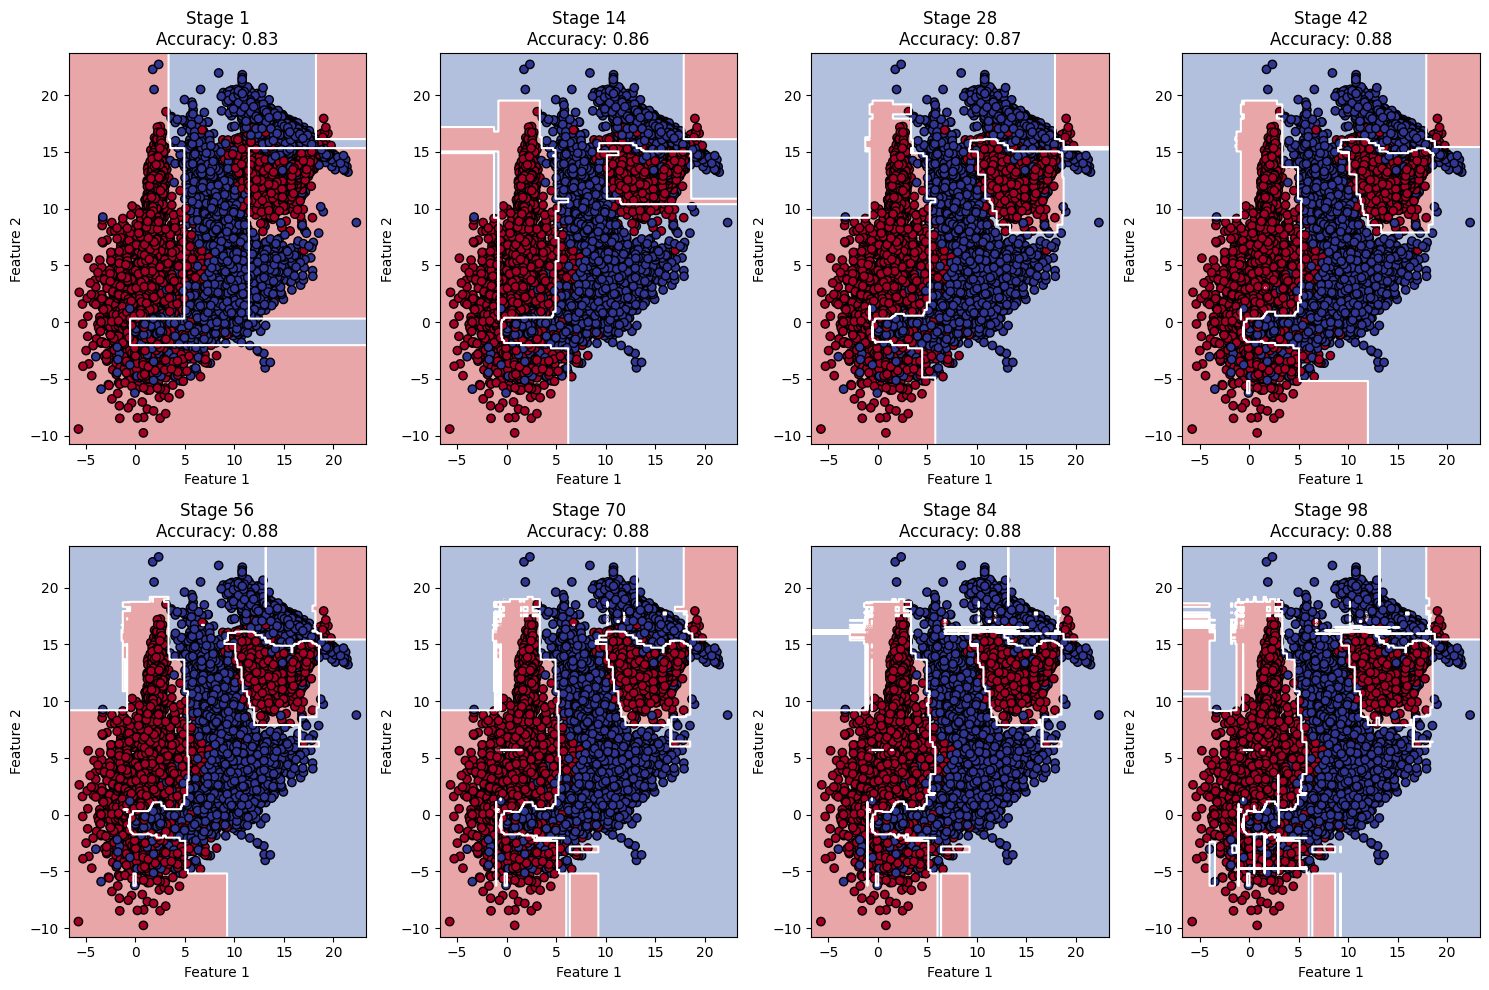

In [37]:
plot_decision_boundaries(ada_best, X_train, y_train,states)


## Metrics Report

In [38]:
Ada_report=Report(ada_best, X_train, y_train, X_test, y_test)
Ada_report


Training      Test
Accuracy   0.884708  0.872333
Precision  0.884827  0.872589
Recall     0.884708  0.872333
F1 Score   0.884698  0.872321

## Accuracy & n_estimators

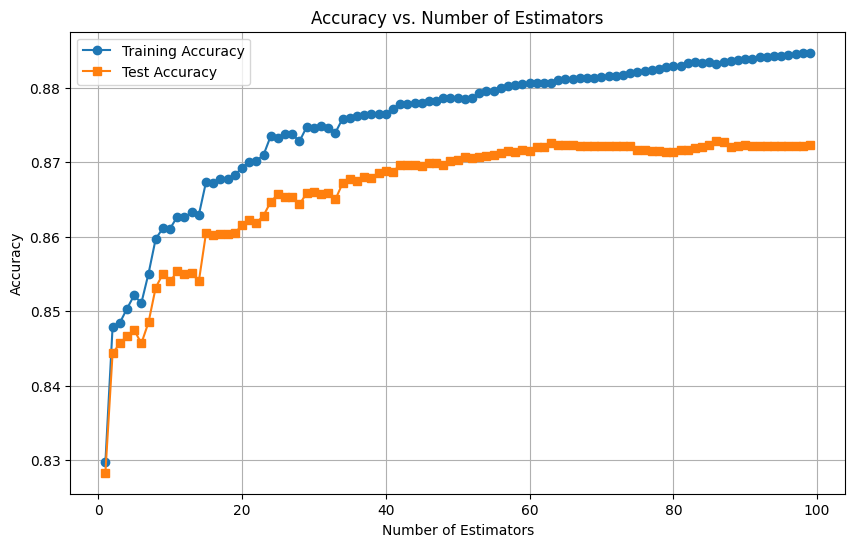

In [39]:
plot_accuracy_vs_n_estimators(ada_best,X_train, y_train, X_test, y_test,range(1,100))

# Phase 4

In [40]:
class StackedLearner(BaseEstimator, ClassifierMixin):
    def __init__(self, base_learners, meta_learner):
        self.base_learners = base_learners
        self.meta_learner = meta_learner
    
    def fit(self, X, y):
        self.base_learners_ = [clone(clf) for clf in self.base_learners]
        self.meta_learner_ = clone(self.meta_learner)
        
        base_predictions = np.zeros((X.shape[0], len(self.base_learners_)))
        for i, clf in enumerate(self.base_learners_):
            clf.fit(X, y)
            base_predictions[:, i] = clf.predict(X)
        
        self.meta_learner_.fit(base_predictions, y)
        return self
    
    def predict(self, X):
        base_predictions = np.zeros((X.shape[0], len(self.base_learners_)))
        for i, clf in enumerate(self.base_learners_):
            base_predictions[:, i] = clf.predict(X)
        
        return self.meta_learner_.predict(base_predictions)


In [24]:
classifiers_and_params = [
    (RandomForestClassifier(), {'n_estimators': [50, 100], 'max_depth': [None,5, 10],'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2,5]}),
    (SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['rbf'],'gamma':['auto','scale']}),
    (LogisticRegression(), {'C': [0.1, 1, 10]}),
    (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]})
]

base_learners = []
for clf, param_grid in classifiers_and_params:
    best_model, best_params = perform_grid_search(clf, param_grid, X_train, y_train)
    print(f"Best params for {clf.__class__.__name__}: {best_params}")
    base_learners.append(best_model)

meta_learner = LogisticRegression()

stacked_model = StackedLearner(base_learners=base_learners, meta_learner=meta_learner)
stacked_model.fit(X_train, y_train)

Best params for RandomForestClassifier: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best params for SVC: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best params for LogisticRegression: {'C': 0.1}
Best params for KNeighborsClassifier: {'n_neighbors': 7}


StackedLearner(base_learners=[RandomForestClassifier(max_depth=10,
                                                     min_samples_split=5),
                              SVC(C=10, gamma='auto', probability=True),
                              LogisticRegression(C=0.1),
                              KNeighborsClassifier(n_neighbors=7)],
               meta_learner=LogisticRegression())

In [ ]:
dump(stacked_model,"stacked_model")

In [42]:
r_stacked_model=load("stacked_model")

## Metrics Report

In [43]:
Stacked_Report=Report(r_stacked_model, X_train, y_train, X_test, y_test)
Stacked_Report

Training      Test
Accuracy   0.895083  0.862000
Precision  0.895089  0.862060
Recall     0.895083  0.862000
F1 Score   0.895083  0.861999

# Extra


In [ ]:
class RobustStackedLearner(BaseEstimator, ClassifierMixin):
    def __init__(self, base_learners, meta_learner, overfit_threshold=0.7, cv=5):
        self.base_learners = base_learners
        self.meta_learner = meta_learner
        self.overfit_threshold = overfit_threshold
        self.cv = cv

    def _is_overfitted(self, clf, X, y):
        """Determine if the model is overfitted based on cross-validation."""
        cv_scores = cross_val_score(clf, X, y, cv=self.cv, scoring='accuracy')
        clf.fit(X, y)
        train_score = clf.score(X, y)
        mean_cv_score = np.mean(cv_scores)
        
        return (train_score - mean_cv_score) > self.overfit_threshold

    def fit(self, X, y):
        n_samples, n_learners = X.shape[0], len(self.base_learners)
        self.base_learners_ = [clone(clf) for clf in self.base_learners]
        self.meta_learner_ = clone(self.meta_learner)
        
        oof_predictions = np.zeros((n_samples, n_learners))
        for i, clf in enumerate(self.base_learners_):
            if self._is_overfitted(clf, X, y):
                print(f"classifire {i+1} is overfitted")
                for j in range(n_samples):
                    X_train, y_train = np.delete(X, j, axis=0), np.delete(y, j)
                    clf.fit(X_train, y_train)
                    oof_predictions[j, i] = clf.predict([X[j]])
            else:
                clf.fit(X, y)
                oof_predictions[:, i] = clf.predict(X)
        
        self.meta_learner_.fit(oof_predictions, y)
        return self

    def predict(self, X):
        base_predictions = np.zeros((X.shape[0], len(self.base_learners_)))
        for i, clf in enumerate(self.base_learners_):
            base_predictions[:, i] = clf.predict(X)
        
        return self.meta_learner_.predict(base_predictions)


### robust verison

In [ ]:
base_learners_oof = copy.copy(base_learners)
oof_model=DecisionTreeClassifier(max_depth=None,min_samples_leaf=1,min_samples_split=2)

base_learners_oof.append(oof_model)

meta_learner_oof = LogisticRegression()

stacked_model_oof = RobustStackedLearner(base_learners=base_learners_oof, meta_learner=meta_learner_oof)
stacked_model_oof.fit(X_train,y_train) 

In [ ]:
dump(stacked_model_oof,"stacked_model_oof")

In [49]:
r_stacked_model_oof=load("stacked_model_oof")

### overfited verison

In [ ]:
base_learners_of = copy.copy(base_learners)
of_model=DecisionTreeClassifier(max_depth=None,min_samples_leaf=1,min_samples_split=2)

base_learners_of.append(of_model)

meta_learner_of = LogisticRegression()

stacked_model_of = StackedLearner(base_learners=base_learners_of, meta_learner=meta_learner_of)
stacked_model_of.fit(X_train,y_train)

In [ ]:
dump(stacked_model_of,"stacked_model_of")

In [48]:
r_stacked_model_of=load("stacked_model_of")

## Metrics Report

In [50]:
Stacked_oof_Report=Report(r_stacked_model_oof, X_train,y_train, X_test, y_test)
Stacked_oof_Report

Training      Test
Accuracy   0.911042  0.867167
Precision  0.911194  0.867480
Recall     0.911042  0.867167
F1 Score   0.911032  0.867149

In [51]:
Stacked_of_Report=Report(r_stacked_model_of, X_train,y_train, X_test, y_test)
Stacked_of_Report 

Training      Test
Accuracy        1.0  0.819333
Precision       1.0  0.819344
Recall          1.0  0.819333
F1 Score        1.0  0.819328